#### Setup variables

In [27]:
n_mels = 64
frame_width = 0.04
hop_width = 0.02
epochs = 100
clip_length = 10 #s
sequence_length = int(clip_length/hop_width) # 10s/0.02s=500 frames
fs = 44100 #Hz
dropout = 0.3
conv_filters = 128
gru_units = 32
epochs = 100
learning_rate = 0.001

#### Setup file paths and import

In [28]:
import dcase_util
from dcase_util.containers import AudioContainer
import os, numpy
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sed_eval
from scipy import signal
# Setup Keras to use tensorflow as backend
# dcase_util.keras.setup_keras(backend='tensorflow')
import keras
from keras.layers import *
from keras.models import Model
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.compat.v1.Session(config=config)
%matplotlib inline
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import signal
from scipy.stats import entropy
import pandas as pd

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)

# # Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_sed.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    """Get feature filename from audio filename. """
    
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features')):  
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=n_mels, win_length_seconds=frame_width, hop_length_seconds=hop_width, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    

In [45]:
db = dcase_util.datasets.TUTSoundEvents_2017_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

Download packages        :   0%|          | 0/4 [00:00<?, ?it/s]

TUT-sound-events-2017-development.meta: 0.00B [00:00, ?B/s]

TUT-sound-events-2017-development.audio.1: 0.00B [00:00, ?B/s]

TUT-sound-events-2017-development.audio.2: 0.00B [00:00, ?B/s]

Extract packages         :   0%|          | 0/4 [00:00<?, ?it/s]

Extract                  :   0%|          | 0/4 [00:00<?, ?it/s]

Extract                  :   0%|          | 0/82 [00:00<?, ?it/s]

Extract                  :   0%|          | 0/23 [00:00<?, ?it/s]

Extract                  :   0%|          | 0/4 [00:00<?, ?it/s]

#### Setup event length in asc order

In [30]:
event_labels = db.event_labels()
data = db.meta.stats()
log.table(
    cell_data=[
        data['events']['event_label_list'],
        data['events']['count'],
        data['events']['length'],
        data['events']['avg_length'],
    ],
    column_headers=['Event label', 'Event count', 'Total length', 'Average event length'],
    column_types=['str20', 'int', 'float2', 'float2'],
    scaling=100
)
event_lengths = pd.DataFrame({'event_label':data['events']['event_label_list'],'length':data['events']['length']}).sort_values('length')
print(data['events']['length'].sum())

Event label,Event count,Total length,Average event length
(object) banging,15,11.36,0.76
(object) rustling,41,131.20,3.20
(object) snapping,42,18.76,0.45
bird singing,162,1081.62,6.68
car passing by,74,549.38,7.42
children shouting,23,46.17,2.01
cupboard,27,17.59,0.65
cutlery,56,41.50,0.74
dishes,94,116.97,1.24
drawer,23,18.36,0.80


3365.0733510000005


### Generate per event SF and SE

In [ ]:
df = pd.DataFrame()
for i, audio_filename in enumerate(db.train(2)):
    print(f"{i} - {audio_filename['event_label']} in {audio_filename['identifier']} from {audio_filename['onset']}s to {audio_filename['offset']}s")
    continue
    # Get audio in a container, mixdown of a stereo signal
    audio_container = dcase_util.containers.AudioContainer().load(
      filename=audio_filename['filename']
    ).mixdown()
    # Set focus
    audio_container.set_focus(start_seconds=audio_filename['onset'], stop_seconds=audio_filename['offset'])
#     print(audio_container,audio_container.shape)
    event_label = audio_filename['event_label']

    y = audio_container.get_focused()
    S = librosa.feature.melspectrogram(y=y, sr=44100, n_mels=64,fmax=8000)
    SF = librosa.feature.spectral_flatness(y=y)
#     S, phase = librosa.magphase(librosa.stft(y))
    SF = librosa.feature.spectral_flatness(S=S)

    sfp = SF[0,1:];
    mean_sfp = np.mean(sfp)

#     print(sfp.shape)
#     plt.plot(sfp)
#     plt.show()
    
#     fig, ax = plt.subplots()
#     plt.specgram(y,Fs=sr)
#     plt.title(f'{event_label}')
    
    freqs, psd = signal.welch(y)
    sigma_psd = psd.sum()
    npsd = psd/sigma_psd
#     plt.figure(figsize=(5, 5))
#     plt.semilogy(freqs, npsd)
#     plt.title(f'{event_label}')

    SE = entropy(npsd,base=2) 
    
    df = df.append({'event':event_label,'SF':mean_sfp,'SE':SE},ignore_index=True)
    


    print(f'Mean SF is {mean_sfp}')
    print(f'SE is {SE}\n')
    
print(df)
# df.to_csv('signal_test_base2.csv',index=False)

#     # Create extractor
#     mel_extractor = dcase_util.features.MelExtractor(n_mels=n_mels)

#     # Extract features
#     mels = mel_extractor.extract(audio_container.get_focused())


#     dcase_util.containers.DataMatrix2DContainer(
#         data=mels,
#         time_resolution=mel_extractor.hop_length_seconds
#     ).plot()

### Generate file list

In [31]:
current_fold = 2
training_files, validation_files = db.validation_split(
    validation_amount=0.3, 
    fold=current_fold, 
    iterations=50,
    disable_progress_bar=False
)
train_meta = db.train(current_fold).filter(file_list=training_files)
validation_meta = db.train(current_fold).filter(file_list=validation_files)

Generate validation split candidates:   0%|          | 0/50 [00:00<?, ?it/s]

Generate validation split candidates:   0%|          | 0/50 [00:00<?, ?it/s]

### Inactive frame SE

In [18]:
# Test inactive frame SE

df = pd.DataFrame()
for i,audio_filename in enumerate(train_meta.event_inactivity()):
    print(f"{i} - {audio_filename['event_label']} from {audio_filename['onset']}s to {audio_filename['offset']}s")
    # Get audio in a container, mixdown of a stereo signal
    audio_container = dcase_util.containers.AudioContainer().load(
      filename=audio_filename['filename']
    ).mixdown()
    # Set focus
    audio_container.set_focus(start_seconds=audio_filename['onset'], stop_seconds=audio_filename['offset'])
#     print(audio_container,audio_container.shape)
    event_label = audio_filename['event_label']

    y = audio_container.get_focused()
    freqs, psd = signal.welch(y)
    sigma_psd = psd.sum()
    npsd = psd/sigma_psd

    SE = entropy(npsd,base=129) 
    
    df = df.append({'event':event_label,'SE':SE},ignore_index=True)
    print(f'SE is {SE}\n')


    

0 - inactivity from 0.0s to 4.06115s
SE is 0.5639299740831091

1 - inactivity from 9.262402s to 13.755747s
SE is 0.6521071660192732

2 - inactivity from 14.202846s to 16.661891s
SE is 0.7583603660495406

3 - inactivity from 17.131345s to 18.785612s
SE is 0.710617699757424

4 - inactivity from 19.165646s to 35.894602s
SE is 0.6765256956608717

5 - inactivity from 38.338743s to 38.748584s
SE is 0.4897199155921581

6 - inactivity from 39.508653s to 40.499722s
SE is 0.4122488745707999

7 - inactivity from 41.334307s to 57.683229s
SE is 0.4786192629378703

8 - inactivity from 58.689202s to 59.374754s
SE is 0.27742980529453737

9 - inactivity from 59.985789s to 61.200408s
SE is 0.5785985253828873

10 - inactivity from 61.789089s to 62.750352s
SE is 0.4331880868293065

11 - inactivity from 63.301774s to 63.592388s
SE is 0.45873039968967616

12 - inactivity from 64.710136s to 68.346541s
SE is 0.6593279143235566

13 - inactivity from 69.002287s to 69.732548s
SE is 0.448706910328351

14 - inacti

SE is 0.5627374988209223

113 - inactivity from 148.995472s to 149.65498s
SE is 0.21837780831752404

114 - inactivity from 150.006008s to 150.213433s
SE is 0.19573917482844047

115 - inactivity from 150.782524s to 151.681369s
SE is 0.21105191528121256

116 - inactivity from 153.064207s to 153.362049s
SE is 0.1676482280802829

117 - inactivity from 157.430784s to 158.090291s
SE is 0.6821058042659852

118 - inactivity from 158.813622s to 158.946587s
SE is 0.2020615987841614

119 - inactivity from 159.39335s to 159.403987s
SE is 0.34592544950714393

120 - inactivity from 159.818839s to 160.052857s
SE is 0.20227636952299893

121 - inactivity from 160.568762s to 160.590037s
SE is 0.19738195664945413

122 - inactivity from 161.520793s to 161.925007s
SE is 0.5927343715234831

123 - inactivity from 163.493997s to 163.552501s
SE is 0.35194660186466

124 - inactivity from 166.206486s to 166.945773s
SE is 0.22070478723607348

125 - inactivity from 167.706334s to 167.738245s
SE is 0.15699154812433

SE is 0.3646436149226347

223 - inactivity from 218.708511s to 219.330897s
SE is 0.35673722493658877

224 - inactivity from 219.953283s to 221.354724s
SE is 0.4229156461910882

225 - inactivity from 224.359345s to 225.273608s
SE is 0.35629967657143274

226 - inactivity from 226.887519s to 228.72463s
SE is 0.3468840854426082

227 - inactivity from 230.973803s to 231.315042s
SE is 0.3148939884209414

228 - inactivity from 237.2041s to 240.80106s
SE is 0.36006063429578494

229 - inactivity from 0.0s to 77.411472s
SE is 0.4900378159685997

230 - inactivity from 77.643185s to 143.97105s
SE is 0.5817316271310229

231 - inactivity from 144.897902s to 146.365418s
SE is 0.43231259721323034

232 - inactivity from 146.539203s to 147.852244s
SE is 0.4591026342561281

233 - inactivity from 148.038901s to 150.642455s
SE is 0.49777250213738244

234 - inactivity from 151.028643s to 153.072224s
SE is 0.46599484493131316

235 - inactivity from 153.181644s to 154.092405s
SE is 0.44827662768004767

236 - 

SE is 0.4692316631101587

334 - inactivity from 35.871212s to 36.672611s
SE is 0.3038810230834743

335 - inactivity from 48.869973s to 65.584309s
SE is 0.2722140744995537

336 - inactivity from 67.309808s to 75.285449s
SE is 0.30655340798602954

337 - inactivity from 77.578446s to 78.981852s
SE is 0.2949205271164903

338 - inactivity from 80.50796s to 84.595476s
SE is 0.29152787225795873

339 - inactivity from 85.431385s to 90.270452s
SE is 0.26853939886145234

340 - inactivity from 98.798252s to 99.944751s
SE is 0.26405180883331963

341 - inactivity from 101.965502s to 106.758555s
SE is 0.2719289018702426

342 - inactivity from 109.036214s to 109.48101s
SE is 0.3472297653187534

343 - inactivity from 111.252522s to 111.996404s
SE is 0.3415779906133757

344 - inactivity from 115.516423s to 117.824757s
SE is 0.27282242340389284

345 - inactivity from 121.682207s to 121.847088s
SE is 0.24309369131121078

346 - inactivity from 123.269666s to 123.837164s
SE is 0.26222299448525666

347 - in

mean sf is 0.35059864382838335


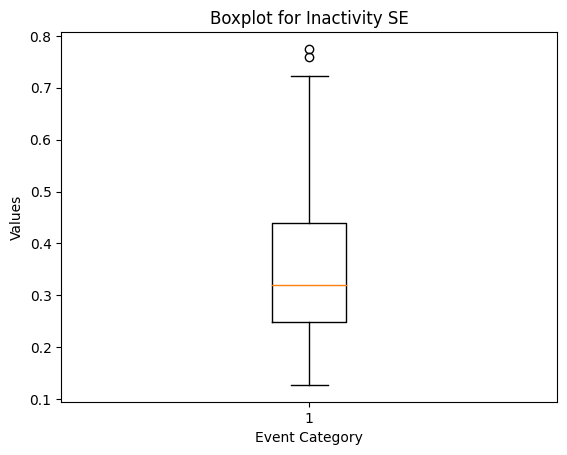

In [20]:
# Draw Inactive frame SE boxplot

# Create a figure and axes to draw the boxplots
fig, ax = plt.subplots()

# Draw the boxplots for each category
ax.boxplot(df['SE'])

# Set the title, labels, and legend
plt.title('Boxplot for Inactivity SE')
plt.xlabel('Event Category')
plt.ylabel('Values')
# plt.yscale('log') 

print(f'mean sf is {df.SE.mean()}')

### SF boxplot

In [14]:
data = pd.read_csv('signal_test.csv',index_col=False)
data.SF = data.SF/0.03
data['event'] = pd.Categorical(data['event'], categories=event_lengths.event_label, ordered=True)
print(data)
# Group the data by 'Event' categories
grouped_data = data.groupby('event')

# Create a list to store the data for each category
boxplot_data = []

# Iterate over the groups and collect data for each category
for category, group in grouped_data:
    boxplot_data.append(group['SF'].tolist())

# Create a figure and axes to draw the boxplots
fig, ax = plt.subplots()

# Draw the boxplots for each category
ax.boxplot(boxplot_data, labels=grouped_data.groups.keys())

# Set the title, labels, and legend
plt.title('Boxplot by Event Category')
plt.xlabel('Event Category')
plt.ylabel('Values')
plt.yscale('log') 
plt.xticks(rotation=90)


# Show the plot
plt.show()

NameError: name 'event_lengths' is not defined

### SE boxplot

                 event            SF        SE
0    water tap running  9.505288e-02  0.735412
1               dishes  6.892668e-02  0.654973
2               dishes  7.956695e-02  0.688673
3               dishes  6.158160e-02  0.673155
4               dishes  1.002897e-01  0.718296
..                 ...           ...       ...
777       wind blowing  3.060380e-05  0.256570
778       wind blowing  2.532386e-05  0.203960
779       bird singing  2.491341e-05  0.160133
780       wind blowing  2.221045e-05  0.158925
781       bird singing  7.031208e-07  0.154811

[782 rows x 3 columns]
          event_label       length
0    (object) banging    11.358199
6            cupboard    17.587900
9              drawer    18.356186
2   (object) snapping    18.760247
10     glass jingling    20.695214
7             cutlery    41.498631
5   children shouting    46.172561
8              dishes   116.965304
1   (object) rustling   131.203545
16       wind blowing   133.996297
11      object impact   156

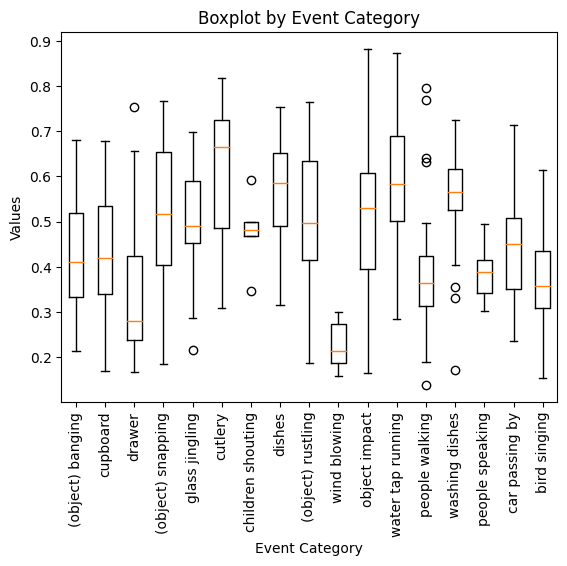

In [33]:
data = pd.read_csv('signal_test.csv',index_col=False)
data['event'] = pd.Categorical(data['event'], categories=event_lengths.event_label, ordered=True)
print(data)
print(event_lengths)

# Group the data by 'Event' categories
grouped_data = data.groupby('event')

# Create a list to store the data for each category
boxplot_data = []

# Iterate over the groups and collect data for each category
for category, group in grouped_data:
    boxplot_data.append(group['SE'].tolist())

# Create a figure and axes to draw the boxplots
fig, ax = plt.subplots()

# Draw the boxplots for each category
ax.boxplot(boxplot_data, labels=grouped_data.groups.keys())

# Set the title, labels, and legend
plt.title('Boxplot by Event Category')
plt.xlabel('Event Category')
plt.ylabel('Values')
# plt.yscale('log') 
plt.xticks(rotation=90)


# Show the plot
plt.show()

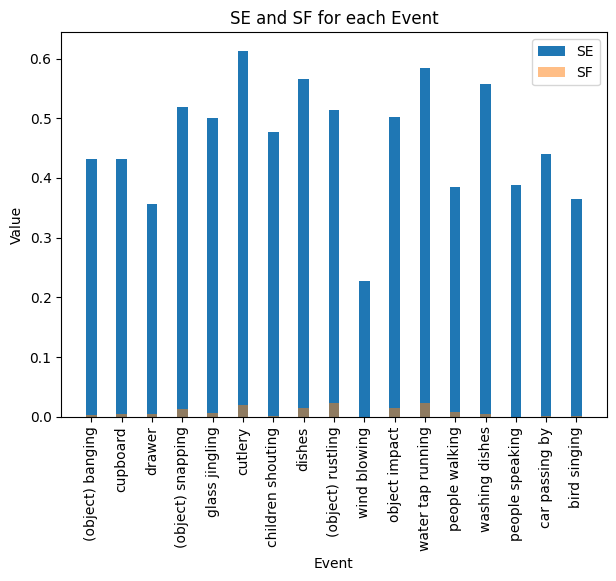

In [44]:
df = data.groupby('event').mean().reset_index()

# Plotting the bar plot
x = range(len(mean_se))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, df['SE'], width, label='SE')
rects2 = ax.bar(x, df['SF'], width, label='SF', alpha=0.5)

ax.set_ylabel('Value')
ax.set_xlabel('Event')
ax.set_title('SE and SF for each Event')
ax.set_xticks(x)
ax.set_xticklabels(df['event'])
ax.legend()

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()